## Analyzing maizsim output

Analyzing the first batch of control simulations. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/con

In [87]:
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

### 1. Figure out where sites are located

In [48]:
df_siteinfo = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_info.csv', dtype='str', usecols=[1,2,3,4,5])
df_siteyear = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_year_crithr1.csv', dtype='str', usecols=[1,2])

In [63]:
df_siteinfo.head()

,site,city,state,lat,lon
0,03103,FLAGSTAFF,AZ,35.08,111.4
1,03812,ASHEVILLE,NC,35.26,82.32
2,03813,MACON,GA,32.42,83.39
3,03820,AUGUSTA,GA,33.22,81.58
4,03822,SAVANNAH,GA,32.08,81.12


In [64]:
df_siteyear.head()

,site,year
0,03103,1964
1,03103,1988
2,03812,1973
3,03812,1975
4,03812,1979


In [56]:
df_siteinfo

,site,city,state,lat,lon
0,03103,FLAGSTAFF,AZ,35.08,111.4
1,03812,ASHEVILLE,NC,35.26,82.32
2,03813,MACON,GA,32.42,83.39
3,03820,AUGUSTA,GA,33.22,81.58
4,03822,SAVANNAH,GA,32.08,81.12
...,...,...,...,...,...
232,94846,CHICAGO,IL,41.47,87.45
233,94847,DETROIT,MI,42.25,83.01
234,94849,ALPENA,MI,45.04,83.34
235,94860,GRAND RAPIDS,MI,42.53,85.31


In [183]:
site_info = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
site_years = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_years.csv", index_col=0, dtype=str)
df_siteyears = pd.merge(left=site_years, right=site_info, how="inner")
df_siteyears = df_siteyears[df_siteyears.site!='41415'] # exclunding Gwam
df_siteyears.head()

,site,years,city,state,lat,lon
0,03103,21,FLAGSTAFF,AZ,35.08,111.4
1,03812,20,ASHEVILLE,NC,35.26,82.32
2,03813,21,MACON,GA,32.42,83.39
3,03820,19,AUGUSTA,GA,33.22,81.58
4,03822,20,SAVANNAH,GA,32.08,81.12


In [184]:
df_siteyears.lat = pd.to_numeric(df_siteyears.lat)
df_siteyears.lon = pd.to_numeric(df_siteyears.lon)

In [223]:
# subsetting areas
test = df_siteyears[(df_siteyears.lat>18) & (df_siteyears.lat<56) &
                    (df_siteyears.lon>0) & (df_siteyears.lon<150)]

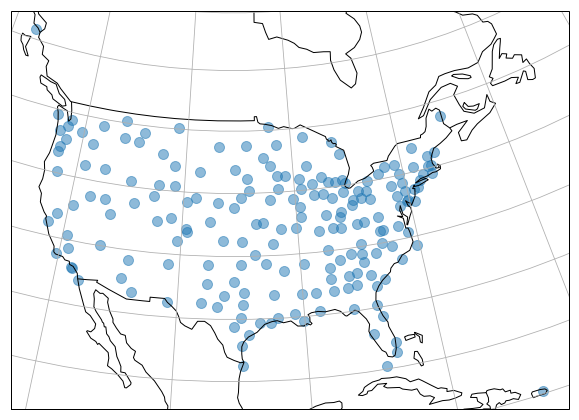

In [222]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax.scatter(test.lon.astype(float)*-1, test.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=100, alpha= 0.5)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()

plt.show()

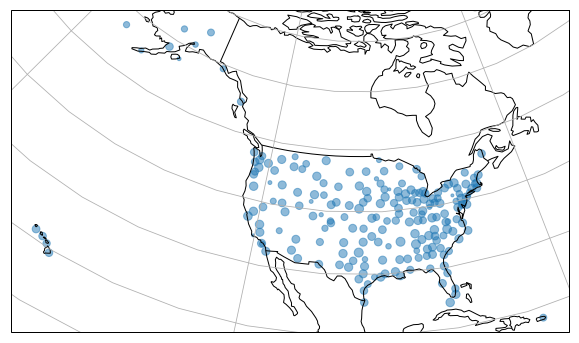

In [221]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_siteyears.lon.astype(float)*-1, df_siteyears.lat.astype(float), 
           transform=ccrs.PlateCarree(), s= df_siteyears.years.astype(float)*3, alpha= 0.5)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()

plt.show()

### 2. Load in all simulation outputs

In [218]:
files = glob.glob('/home/disk/eos8/ach315/upscale/sims/con/out1/*')

In [219]:
len(files)

1560

In [23]:
cols = ['jday', 'time', 'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 'RH', 
        'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

In [28]:
df_test = pd.read_csv(files[2])
df_test.columns = cols
df_test.head()

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
04/01/1975,27485,0,0.0,0,0,0.0,0.0,0.0,60.19,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1975,27485,1,0.0,0,0,0.0,0.0,0.0,75.95,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1975,27485,2,0.0,0,0,0.0,0.0,0.0,75.95,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1975,27485,3,0.0,0,0,0.0,0.0,0.0,76.04,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1975,27485,4,0.0,0,0,0.0,0.0,0.0,85.05,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""


In [ ]:
dm_ears = list()

for file in files:
    df = pd.read_csv(file)
    df.columns = cols
    ear = df.dm_ear.iloc[-1]
    dm_ears.append(ear)

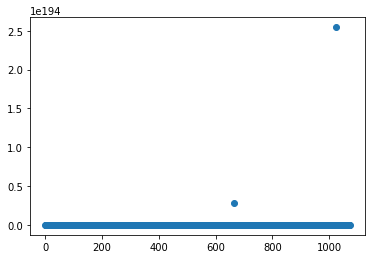

In [103]:
plt.scatter(list(np.arange(len(dm_ears))), dm_ears)

### 3. Create master df that includes lat/lon, year, yield